## Предсказание объемов продаж на ограниченом объеме

In [1]:
%pylab inline
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import metrics
from sklearn import grid_search
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import SGDRegressor

import xgboost as xgb

from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import auc, mean_squared_error, log_loss, roc_auc_score, zero_one_loss, accuracy_score, precision_score, recall_score

from hyperopt import hp, tpe, STATUS_OK, Trials, rand
from hyperopt import fmin as fminHyper

import MySQLdb

from math import ceil

from datetime import timedelta
import datetime

from sklearn.model_selection import TimeSeriesSplit

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


**Загрузка данных**

In [215]:
%%time
db_connection = MySQLdb.connect(host="194.247.15.117", 
                     port=7806,
                     user="bar",
                     passwd="PASSWORD",
                     db="Inventory")

data = pd.read_sql('SELECT * FROM Inventory.vTotalPassengers_v2', con=db_connection)
db_connection.close()

print(len(data))

301853
Wall time: 12min 2s


In [216]:
data.sort_values(by=['FlightID', 'DptDt'], inplace=True)
data.drop(data[data.DptDt > datetime.date(2017, 3, 31)].index.values, inplace = True)
data.tail(25)

,FlightID,Code,seatsAvail,authLevel,resHoldTotal,reportDt,orig,dest,DptDt,Carrier,fltNr,opsSuffix,fltNrDptDt,fltNrArrDt,DptTime,ArrTime
301828,277077,K,39,60.0,0.0,2014-08-31,ZELDO,KZNP,2014-08-30,FPC,50,M,2014-08-29,2014-08-30,6,8
301829,277124,F,8,12.0,0.0,2014-08-31,KUF,RUZVK,2014-08-29,FPC,9,J,2014-08-29,2014-08-30,18,0
301830,277124,C,28,72.0,0.0,2014-08-31,KUF,RUZVK,2014-08-29,FPC,9,J,2014-08-29,2014-08-30,18,0
301831,277124,B,1,147.0,1.0,2014-08-31,KUF,RUZVK,2014-08-29,FPC,9,J,2014-08-29,2014-08-30,18,0
301832,277124,Y,17,147.0,5.0,2014-08-31,KUF,RUZVK,2014-08-29,FPC,9,J,2014-08-29,2014-08-30,18,0
301833,277124,F,8,12.0,0.0,2014-08-31,KUF,RZN1,2014-08-29,FPC,9,J,2014-08-29,2014-08-30,18,4
301834,277124,C,15,72.0,1.0,2014-08-31,KUF,RZN1,2014-08-29,FPC,9,J,2014-08-29,2014-08-30,18,4
301835,277124,B,0,147.0,5.0,2014-08-31,KUF,RZN1,2014-08-29,FPC,9,J,2014-08-29,2014-08-30,18,4
301836,277124,Y,17,147.0,3.0,2014-08-31,KUF,RZN1,2014-08-29,FPC,9,J,2014-08-29,2014-08-30,18,4
301837,277124,F,8,12.0,4.0,2014-08-31,KUF,MOWKZ,2014-08-29,FPC,9,J,2014-08-29,2014-08-30,18,7


**Предобработка данных**

In [217]:
# drop stuff
data.drop('reportDt', axis = 1, inplace = True)
data.drop('seatsAvail', axis = 1, inplace = True)
data.drop('authLevel', axis = 1, inplace = True)
data.drop('Carrier', axis = 1, inplace = True)

In [218]:
# make flight id 
data['flightNrSf'] = [str(data.fltNr.values[x]) + data.opsSuffix.values[x] for x in range(0, len(data.fltNr.values))]
data.drop('fltNr', axis = 1, inplace = True)
data.drop('opsSuffix', axis = 1, inplace = True)

In [219]:
# словари для кодирования позедов, сегментов и классов вагонов
segment_dict = dict(enumerate(set(np.append(data.orig.unique(), data.dest.unique()))))
flightNrSf_dict = dict(enumerate(data.flightNrSf.unique()))
code_dict = dict(enumerate(data.Code.unique()))

# кодируем сегмент
data.orig = data.orig.map(lambda x: list(segment_dict.keys())[list(segment_dict.values()).index(x)])
data.dest = data.dest.map(lambda x: list(segment_dict.keys())[list(segment_dict.values()).index(x)])

# кодируем поезда
data.flightNrSf = data.flightNrSf.map(lambda x: list(flightNrSf_dict.keys())[list(flightNrSf_dict.values()).index(x)])

# кодируем вагоны
data.Code = data.Code.map(lambda x: list(code_dict.keys())[list(code_dict.values()).index(x)])

In [220]:
print(flightNrSf_dict)

{0: '10J', 1: '50M', 2: '9J', 3: '49J', 4: '337J', 5: '337ZH', 6: '138J', 7: '137YQ', 8: '102J', 9: '101J', 10: '88J', 11: '87J'}


In [221]:
print(segment_dict)

{0: 'SYZR1', 1: 'KOVYL', 2: 'SGC', 3: 'VOEVD', 4: 'BAZRN', 5: 'ARZM1', 6: 'RZN1', 7: 'SVX', 8: 'NEREK', 9: 'SHILV', 10: 'BEZNC', 11: 'KZNP', 12: 'AZOQM', 13: 'NJC', 14: 'IVANV', 15: 'KMNUR', 16: 'GFBMH', 17: 'URMAR', 18: 'OBSHA', 19: 'SKX', 20: 'INZA', 21: 'SXMBV', 22: 'BARYS', 23: 'KANAS', 24: 'WINOP', 25: 'YTNPR', 26: 'MAKSA', 27: 'ZUBVP', 28: 'UZHOV', 29: 'MVISH', 30: 'SHSTH', 31: 'SASOV', 32: 'LANGP', 33: 'CEK', 34: 'KOVRV', 35: 'NEKOZ', 36: 'KUZNT', 37: 'VOLGA', 38: 'RYBP', 39: 'LEDGL', 40: 'RUZVK', 41: 'TOX', 42: 'SONKV', 43: 'NAVAS', 44: 'KUZOV', 45: 'VEKVK', 46: 'BOLOG', 47: 'PEZ1', 48: 'TJM', 49: 'CHAPV', 50: 'ZELDO', 51: 'PYTJA', 52: 'POTMA', 53: 'OKUL', 54: 'GOJ', 55: 'MUROM', 56: 'MOWKZ', 57: 'BEZHK', 58: 'KUF', 59: 'IARGL', 60: 'TORBV', 61: 'NOCKA', 62: 'NOVKU'}


In [222]:
# make segment
data['segment'] = data.orig.astype('str') + '_' + data.dest.astype('str')
data.drop('orig', axis = 1, inplace = True)
data.drop('dest', axis = 1, inplace = True)

In [223]:
print(len(data.segment.unique()))

511


In [224]:
# drop bad segments
jig_flight = (6, 7)
keep_segments = set(np.append(data.segment[data.flightNrSf == jig_flight[0]].unique(), data.segment[data.flightNrSf == jig_flight[1]].unique()))

drop_indexes = list()
for segment in data.segment.unique():
    if segment not in keep_segments:
        drop_indexes = np.append(drop_indexes, data[data.segment == segment].index.values)

data.drop(drop_indexes, axis = 0, inplace = True)

In [225]:
print(len(data.segment.unique()))

107


In [226]:
# drop bad flights
data.drop(data[data.flightNrSf == 4].index.values, inplace = True)
data.drop(data[data.flightNrSf == 8].index.values, inplace = True)

In [227]:
# словарь для повторного кодирования сегментов
segment_sec_dict = dict(enumerate(data.segment.unique()))

# повторно кодируем сегмент
data.segment = data.segment.map(lambda x: list(segment_sec_dict.keys())[list(segment_sec_dict.values()).index(x)])

In [228]:
print(segment_sec_dict)

{0: '56_40', 1: '56_0', 2: '56_58', 3: '40_0', 4: '40_58', 5: '0_58', 6: '56_31', 7: '56_27', 8: '56_1', 9: '56_20', 10: '56_22', 11: '56_49', 12: '31_27', 13: '31_1', 14: '31_40', 15: '31_20', 16: '31_22', 17: '31_0', 18: '31_49', 19: '31_58', 20: '27_1', 21: '27_40', 22: '27_20', 23: '27_22', 24: '27_0', 25: '27_58', 26: '58_40', 27: '58_6', 28: '58_56', 29: '40_6', 30: '40_56', 31: '6_56', 32: '58_1', 33: '40_1', 34: '1_6', 35: '1_56', 36: '56_9', 37: '56_60', 38: '56_24', 39: '56_16', 40: '56_61', 41: '56_4', 42: '56_10', 43: '9_31', 44: '9_60', 45: '9_1', 46: '9_24', 47: '9_40', 48: '9_16', 49: '9_61', 50: '9_20', 51: '9_4', 52: '9_0', 53: '9_10', 54: '9_49', 55: '9_58', 56: '31_60', 57: '31_24', 58: '31_16', 59: '31_61', 60: '31_4', 61: '31_10', 62: '60_1', 63: '60_24', 64: '60_40', 65: '60_16', 66: '1_40', 67: '1_20', 68: '56_52', 69: '58_0', 70: '58_16', 71: '1_22', 72: '1_0', 73: '1_58', 74: '40_20', 75: '40_22', 76: '20_22', 77: '20_0', 78: '20_58', 79: '22_0', 80: '22_58', 8

In [229]:
# кодируем дату
data.DptDt = pd.DatetimeIndex(data.DptDt)
data.fltNrDptDt = pd.DatetimeIndex(data.fltNrDptDt)
data.fltNrArrDt = pd.DatetimeIndex(data.fltNrArrDt)

In [230]:
%%time
from ipywidgets import FloatProgress
from IPython.display import display

f = FloatProgress(min=0, max=len(data.segment.unique()))
display(f)

# сделать в разрезе сегмента - типа вагонa
for segment in unique(data.segment):
    for code in unique(data[data.segment == segment].Code):
        sigma3 = np.mean(data.resHoldTotal[data.Code == code][data.segment == segment].values) + 3 * np.std(data.resHoldTotal[data.Code == code][data.segment == segment].values)
        data.drop(data[data.resHoldTotal >= sigma3][data.Code == code][data.segment == segment].index, axis = 0, inplace = True)
        
        sigma3 = np.mean(data.resHoldTotal[data.Code == code][data.segment == segment].values) - 3 * np.std(data.resHoldTotal[data.Code == code][data.segment == segment].values)
        data.drop(data[data.resHoldTotal <= sigma3][data.Code == code][data.segment == segment].index, axis = 0, inplace = True)

    f.value += 1   

Wall time: 1min 37s


In [231]:
data.reset_index(inplace=True)
data.drop('index', axis = 1, inplace = True)
data

,FlightID,Code,resHoldTotal,DptDt,fltNrDptDt,fltNrArrDt,DptTime,ArrTime,flightNrSf,segment
0,25,1,3.0,2016-05-26,2016-05-26,2016-05-27,20,3,0,0
1,25,2,1.0,2016-05-26,2016-05-26,2016-05-27,20,3,0,0
2,25,3,0.0,2016-05-26,2016-05-26,2016-05-27,20,3,0,0
3,25,0,0.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1
4,25,1,11.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1
5,25,2,32.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1
6,25,3,19.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1
7,25,0,10.0,2016-05-26,2016-05-26,2016-05-27,20,9,0,2
8,25,1,47.0,2016-05-26,2016-05-26,2016-05-27,20,9,0,2
9,25,2,87.0,2016-05-26,2016-05-26,2016-05-27,20,9,0,2


In [232]:
print(len(data[data['flightNrSf'] == 0]), len(data[data['flightNrSf'] == 2]))
print(len(data[data['flightNrSf'] == 1]), len(data[data['flightNrSf'] == 3]))
print(len(data[data['flightNrSf'] == 4]), len(data[data['flightNrSf'] == 5]))
print(len(data[data['flightNrSf'] == 6]), len(data[data['flightNrSf'] == 7]))
print(len(data[data['flightNrSf'] == 8]), len(data[data['flightNrSf'] == 9]))
print(len(data[data['flightNrSf'] == 10]), len(data[data['flightNrSf'] == 11]))

print('')

print(len(data[data['flightNrSf'] == 0][data['DptDt'] > datetime.date(2017, 3, 1)]), len(data[data['flightNrSf'] == 2][data['DptDt'] > datetime.date(2017, 3, 1)]))
print(len(data[data['flightNrSf'] == 1][data['DptDt'] > datetime.date(2017, 3, 1)]), len(data[data['flightNrSf'] == 3][data['DptDt'] > datetime.date(2017, 3, 1)]))
print(len(data[data['flightNrSf'] == 4][data['DptDt'] > datetime.date(2017, 3, 1)]), len(data[data['flightNrSf'] == 5][data['DptDt'] > datetime.date(2017, 3, 1)]))
print(len(data[data['flightNrSf'] == 6][data['DptDt'] > datetime.date(2017, 3, 1)]), len(data[data['flightNrSf'] == 7][data['DptDt'] > datetime.date(2017, 3, 1)]))
print(len(data[data['flightNrSf'] == 8][data['DptDt'] > datetime.date(2017, 3, 1)]), len(data[data['flightNrSf'] == 9][data['DptDt'] > datetime.date(2017, 3, 1)]))
print(len(data[data['flightNrSf'] == 10][data['DptDt'] > datetime.date(2017, 3, 1)]), len(data[data['flightNrSf'] == 11][data['DptDt'] > datetime.date(2017, 3, 1)]))

18789 19877
18168 9686
0 0
9062 6881
0 0
0 0

512 528
1120 677
0 0
884 658
0 0
0 0


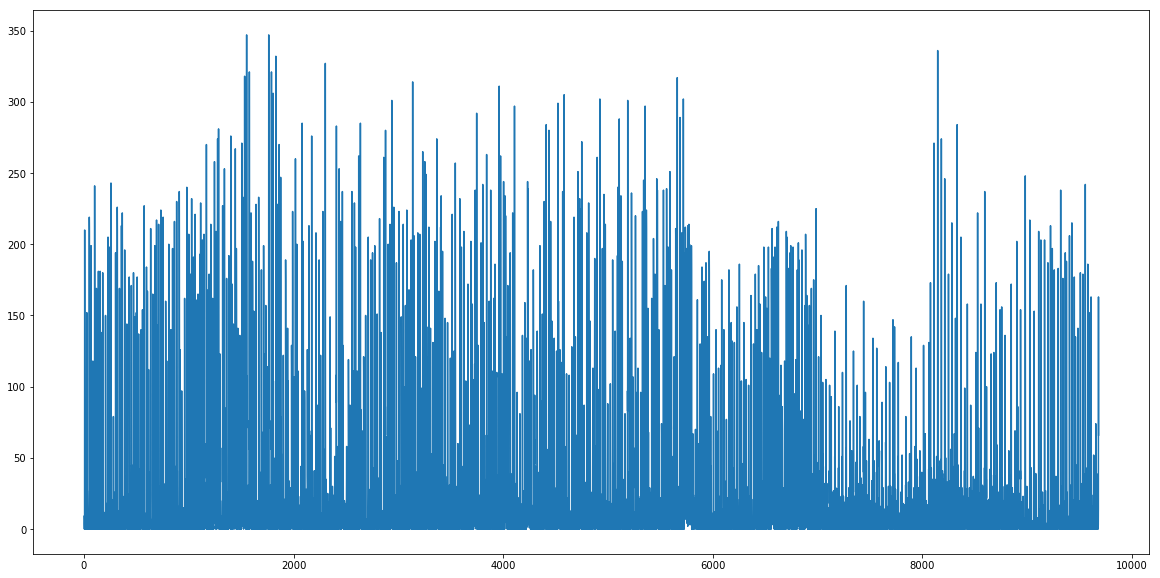

In [245]:
plt.figure(figsize=(20, 10))
fn = 3

x = np.arange(0, len(data[data.flightNrSf == fn]))
plt.plot(x, data[data.flightNrSf == fn].resHoldTotal)

**Обогащение данных**

In [233]:
# дата

def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

data['DayOfWeekDpt'] = pd.DatetimeIndex(data['DptDt']).dayofweek 
data['WeekOfMonthDpt'] = [week_of_month(x) for x in pd.DatetimeIndex(data['DptDt'])]
data['MonthDpt'] = pd.DatetimeIndex(data['DptDt']).month 
data['QuarterDpt'] = pd.DatetimeIndex(data['DptDt']).quarter 
data['YearDpt'] = pd.DatetimeIndex(data['DptDt']).year
data['IsWeekendDpt'] = data['DayOfWeekDpt'].isin([5,6])*1


data['DayOfWeekArr'] = pd.DatetimeIndex(data['fltNrArrDt']).dayofweek 
data['WeekOfMonthArr'] = [week_of_month(x) for x in pd.DatetimeIndex(data['DptDt'])]
data['MonthArr'] = pd.DatetimeIndex(data['DptDt']).month 
data['QuarterArr'] = pd.DatetimeIndex(data['DptDt']).quarter 
data['YearArr'] = pd.DatetimeIndex(data['DptDt']).year
data['IsWeekendArr'] = data['DayOfWeekArr'].isin([5,6])*1

In [176]:
# # праздники - кодируем
# data['Holiday'] = 0
# holidayDays = ('2017-03-08 00:00:00', '2017-02-23 00:00:00', '2017-01-07 00:00:00', '2017-06-12 00:00:00', '2017-01-01 00:00:00', '2017-05-09 00:00:00',
#                '2016-03-08 00:00:00', '2016-02-23 00:00:00', '2016-01-07 00:00:00', '2016-06-12 00:00:00', '2016-01-01 00:00:00', '2016-05-09 00:00:00',
#                '2015-03-08 00:00:00', '2015-02-23 00:00:00', '2015-01-07 00:00:00', '2015-06-12 00:00:00', '2015-01-01 00:00:00', '2015-05-09 00:00:00',
#                '2014-03-08 00:00:00', '2014-02-23 00:00:00', '2014-01-07 00:00:00', '2014-06-12 00:00:00', '2014-01-01 00:00:00', '2014-05-09 00:00:00')

# for holidayIndex in holidayDays:
#     daysIncr = np.arange(-7, 7)
#     holidayCode = np.append(np.arange(1, 8), np.arange(1, 8)[::-1])
    
#     for i, dayIncr in enumerate(daysIncr):
#         holiday = pd.DatetimeIndex([holidayIndex])[0] + datetime.timedelta(days = int(dayIncr))
#         data.loc[data[data.DptDt == holiday].index.values, 'Holiday'] = holidayCode[i]

In [234]:
data

,FlightID,Code,resHoldTotal,DptDt,fltNrDptDt,fltNrArrDt,DptTime,ArrTime,flightNrSf,segment,...,MonthDpt,QuarterDpt,YearDpt,IsWeekendDpt,DayOfWeekArr,WeekOfMonthArr,MonthArr,QuarterArr,YearArr,IsWeekendArr
0,25,1,3.0,2016-05-26,2016-05-26,2016-05-27,20,3,0,0,...,5,2,2016,0,4,5,5,2,2016,0
1,25,2,1.0,2016-05-26,2016-05-26,2016-05-27,20,3,0,0,...,5,2,2016,0,4,5,5,2,2016,0
2,25,3,0.0,2016-05-26,2016-05-26,2016-05-27,20,3,0,0,...,5,2,2016,0,4,5,5,2,2016,0
3,25,0,0.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1,...,5,2,2016,0,4,5,5,2,2016,0
4,25,1,11.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1,...,5,2,2016,0,4,5,5,2,2016,0
5,25,2,32.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1,...,5,2,2016,0,4,5,5,2,2016,0
6,25,3,19.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1,...,5,2,2016,0,4,5,5,2,2016,0
7,25,0,10.0,2016-05-26,2016-05-26,2016-05-27,20,9,0,2,...,5,2,2016,0,4,5,5,2,2016,0
8,25,1,47.0,2016-05-26,2016-05-26,2016-05-27,20,9,0,2,...,5,2,2016,0,4,5,5,2,2016,0
9,25,2,87.0,2016-05-26,2016-05-26,2016-05-27,20,9,0,2,...,5,2,2016,0,4,5,5,2,2016,0


In [250]:
# сортируем по рейсам и датам
data.sort_values(['FlightID', 'DptDt'], inplace=True)
data.reset_index(inplace=True)
data.drop('index', axis = 1, inplace = True)

In [253]:
# праздники - удаляем\
# data['Holiday'] = 0
holidayDays = ('2017-03-08 00:00:00', '2017-02-23 00:00:00', '2017-01-07 00:00:00', '2017-06-12 00:00:00', '2017-01-01 00:00:00', '2017-05-09 00:00:00',
               '2016-03-08 00:00:00', '2016-02-23 00:00:00', '2016-01-07 00:00:00', '2016-06-12 00:00:00', '2016-01-01 00:00:00', '2016-05-09 00:00:00',
               '2015-03-08 00:00:00', '2015-02-23 00:00:00', '2015-01-07 00:00:00', '2015-06-12 00:00:00', '2015-01-01 00:00:00', '2015-05-09 00:00:00',
               '2014-03-08 00:00:00', '2014-02-23 00:00:00', '2014-01-07 00:00:00', '2014-06-12 00:00:00', '2014-01-01 00:00:00', '2014-05-09 00:00:00')

to_drop = list()
for holidayIndex in holidayDays:
    daysIncr = np.arange(-14, 7)
    
    for i, dayIncr in enumerate(daysIncr):
        holiday = pd.DatetimeIndex([holidayIndex])[0] + datetime.timedelta(days = int(dayIncr))
        data.drop(data[data.DptDt == holiday].index.values, inplace = True)
    
data.reset_index(inplace=True)
data.drop('index', axis = 1, inplace = True)

In [21]:
# # среднее по поездам / классам за все время - поменять логику на сегменты - 
# data['MeanResHoldTotalAll'] = 0.0
# data['MeanResHoldTotalYear'] = 0.0
# for flightNrSf in unique(data.flightNrSf.values):
#     for segment in unique(data.segment[data.flightNrSf == flightNrSf].values):
#         for code in unique(data.Code[data.flightNrSf == flightNrSf][data.segment == segment].values):
#             data['MeanResHoldTotalAll'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment].values)
#             data['MeanResHoldTotalYear'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2015, 1, 1)].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2015, 1, 1)].values)
#             data['MeanResHoldTotalYear'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2016, 1, 1)].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2016, 1, 1)].values)
#             data['MeanResHoldTotalYear'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2017, 1, 1)].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2017, 1, 1)].values)
#             data['MeanResHoldTotalYear'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2018, 1, 1)].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2018, 1, 1)].values)
            

In [254]:
data

,FlightID,Code,resHoldTotal,DptDt,fltNrDptDt,fltNrArrDt,DptTime,ArrTime,flightNrSf,segment,...,MonthDpt,QuarterDpt,YearDpt,IsWeekendDpt,DayOfWeekArr,WeekOfMonthArr,MonthArr,QuarterArr,YearArr,IsWeekendArr
0,25,1,3.0,2016-05-26,2016-05-26,2016-05-27,20,3,0,0,...,5,2,2016,0,4,5,5,2,2016,0
1,25,2,1.0,2016-05-26,2016-05-26,2016-05-27,20,3,0,0,...,5,2,2016,0,4,5,5,2,2016,0
2,25,3,0.0,2016-05-26,2016-05-26,2016-05-27,20,3,0,0,...,5,2,2016,0,4,5,5,2,2016,0
3,25,0,0.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1,...,5,2,2016,0,4,5,5,2,2016,0
4,25,1,11.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1,...,5,2,2016,0,4,5,5,2,2016,0
5,25,2,32.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1,...,5,2,2016,0,4,5,5,2,2016,0
6,25,3,19.0,2016-05-26,2016-05-26,2016-05-27,20,7,0,1,...,5,2,2016,0,4,5,5,2,2016,0
7,25,0,10.0,2016-05-26,2016-05-26,2016-05-27,20,9,0,2,...,5,2,2016,0,4,5,5,2,2016,0
8,25,1,47.0,2016-05-26,2016-05-26,2016-05-27,20,9,0,2,...,5,2,2016,0,4,5,5,2,2016,0
9,25,2,87.0,2016-05-26,2016-05-26,2016-05-27,20,9,0,2,...,5,2,2016,0,4,5,5,2,2016,0


**Временные ряды**

In [ ]:
series = pd.DataFrame(data.groupby(['DptDt'])['resHoldTotal'].sum()).add_suffix('Sum').reset_index()
series.sort_values(['DptDt'], inplace = True)
series

In [ ]:
x = np.arange(0, len(series))
plt.figure(figsize = (20, 15))
plt.plot(series.DptDt, series.resHoldTotalSum)

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data.index = data.index.to_datetime()
    data["weekday"] = pd.DatetimeIndex(data.index).weekday
    data['WeekOfMonth'] = [week_of_month(x) for x in pd.DatetimeIndex(data.index)]
    data['MonthDpt'] = pd.DatetimeIndex(data.index).month 
    data['QuarterDpt'] = pd.DatetimeIndex(data.index).quarter 
    data['YearDpt'] = pd.DatetimeIndex(data.index).year
    data['is_weekend'] = data.weekday.isin([5,6])*1

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [ ]:
def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'nthread' : 4,
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees, early_stopping_rounds=50)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(20, 15))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(20, 15))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

In [ ]:
series.set_index('DptDt', inplace=True)
series.index.name = None
series

In [ ]:
XGB_forecast(series, test_size=0.2, lag_start=5, lag_end=100)

**Деление данных на тренировочную и тестовую выборки**

In [255]:
test_data = data[data.YearDpt == 2017][data.MonthDpt == 3].copy()
test_y = test_data.resHoldTotal.copy()

data = data.drop(test_data.index.values).copy()
y = data.resHoldTotal.copy()

In [256]:
test_data.drop('fltNrArrDt', axis = 1, inplace = True)
test_data.drop('DptDt', axis = 1, inplace = True)
test_data.drop('resHoldTotal', axis = 1, inplace = True)

data.drop('fltNrArrDt', axis = 1, inplace = True)
data.drop('DptDt', axis = 1, inplace = True)
data.drop('resHoldTotal', axis = 1, inplace = True)

In [257]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = list()
y_test = list()


for flt in data.flightNrSf.unique():  
    data1 = data[data.flightNrSf == flt].copy()
    X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, y[data1.index], test_size = 0.2, random_state = 43)
            
    X_train = pd.concat([X_train, X_train1])
    X_test = pd.concat([X_test, X_test1])
    y_train.extend(y_train1)
    y_test.extend(y_test1)

dtrain = xgb.DMatrix(X_train.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), y_train)
dvalid = xgb.DMatrix(X_test.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), y_test)
dtest = xgb.DMatrix(test_data.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), test_y)

**Регрессия**

In [ ]:
from sklearn.linear_model import Ridge
X_ridge = X_train.copy()
X_ridge['Amount'] = y_train
X_ridge.drop('FlightID', axis = 1, inplace = True)
X_ridge.drop('fltNrDptDt', axis = 1, inplace = True)
X_ridge.drop('DptTime', axis = 1, inplace = True)
X_ridge.drop('ArrTime', axis = 1, inplace = True)
X_ridge.drop('DayOfWeekDpt', axis = 1, inplace = True)
X_ridge.drop('WeekOfMonth', axis = 1, inplace = True)
X_ridge.drop('MonthDpt', axis = 1, inplace = True)
X_ridge.drop('QuarterDpt', axis = 1, inplace = True)
X_ridge.drop('YearDpt', axis = 1, inplace = True)
X_ridge.drop('segment', axis = 1, inplace = True)
X_ridge.head()

In [ ]:
X_ridge_test = X_test.copy() 
X_ridge_test['Amount'] = y_test
X_ridge_test.drop('FlightID', axis = 1, inplace = True)
X_ridge_test.drop('fltNrDptDt', axis = 1, inplace = True)
X_ridge_test.drop('DptTime', axis = 1, inplace = True)
X_ridge_test.drop('ArrTime', axis = 1, inplace = True)
X_ridge_test.drop('DayOfWeekDpt', axis = 1, inplace = True)
X_ridge_test.drop('WeekOfMonth', axis = 1, inplace = True)
X_ridge_test.drop('MonthDpt', axis = 1, inplace = True)
X_ridge_test.drop('QuarterDpt', axis = 1, inplace = True)
X_ridge_test.drop('YearDpt', axis = 1, inplace = True)
X_ridge_test.drop('segment', axis = 1, inplace = True)
X_ridge_test.head()

In [ ]:
X_train['ridge predictions'] = 0.0
X_test['ridge predictions'] = 0.0
for flightNrSf in X_ridge.flightNrSf.unique():
    for Code in X_ridge.Store[X_ridge.SKU == sku].unique():
        
        dataset_x = X_ridge[X_ridge.SKU == sku][X_ridge.Store == store].copy()
        if (len(dataset_x.index) > 0):
            dataset_y = dataset_x['Amount']
            dataset_x.drop("Amount", axis = 1, inplace = True)
            dataset_x.drop("Store", axis = 1, inplace = True)
            dataset_x.drop("SKU", axis = 1, inplace = True)
            clf = Ridge(fit_intercept=True, alpha=0.1, random_state=0, normalize=False)
            clf.fit(dataset_x, dataset_y) 
            res = clf.predict(dataset_x)
            X_train['ridge predictions'][X_train[X_train.SKU == sku][X_train.Store == store].index.values] = res
      
        dataset_x_test = X_ridge_test[X_ridge_test.SKU == sku][X_ridge_test.Store == store]
        if (len(dataset_x_test.index) > 0):
            dataset_y_test = dataset_x_test['Amount'].copy()
            dataset_x_test.drop("Amount", axis = 1, inplace = True)
            dataset_x_test.drop("Store", axis = 1, inplace = True)
            dataset_x_test.drop("SKU", axis = 1, inplace = True)
            res = clf.predict(dataset_x_test)
            X_test['ridge predictions'][X_test[X_test.SKU == sku][X_test.Store == store].index.values] = res

**Модель**

In [181]:
def score(params):
    print("Training with params:")
    print(params)
    
    num_round = int(params['n_estimators'])    
    del params['n_estimators']
    params['max_depth'] = (int) (params['max_depth'])
    
    model = xgb.train(params, dtrain, num_round)
    
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 1))
    score = mean_squared_error(y_test, predictions)
    
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [258]:
def optimize(trials):

    space = {
    'n_estimators' : 75,
    'eta' : hp.quniform('eta', 0.05, 0.5, 0.025),
    'max_depth' : hp.quniform('max_depth', 4, 10, 2),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 8, 1),
    'subsample' : hp.quniform('subsample', 0.5, 1, 0.25),
    'gamma' : 0,
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.25),
    'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.5, 1, 0.25),
    'reg_alpha' : hp.quniform('reg_alpha', 0, 1, 0.25),
    'reg_lambda' : hp.quniform('reg_lambda', 0, 1, 0.25),
    'objective': 'reg:linear',
    'nthread' : 4,
    'silent' : 1
    }
    best = fminHyper(score, space, algo=tpe.suggest, trials=trials, max_evals=75)

    print(best)

In [259]:
%%time
trials = Trials()
optimize(trials)

Training with params:
{'min_child_weight': 2.0, 'objective': 'reg:linear', 'silent': 1, 'reg_lambda': 0.25, 'max_depth': 10.0, 'nthread': 4, 'reg_alpha': 0.75, 'colsample_bylevel': 0.75, 'eta': 0.42500000000000004, 'subsample': 1.0, 'colsample_bytree': 0.75, 'gamma': 0, 'n_estimators': 75}
	Score 59.012335461164554


Training with params:
{'min_child_weight': 7.0, 'objective': 'reg:linear', 'silent': 1, 'reg_lambda': 0.75, 'max_depth': 10.0, 'nthread': 4, 'reg_alpha': 0.5, 'colsample_bylevel': 0.75, 'eta': 0.42500000000000004, 'subsample': 0.5, 'colsample_bytree': 0.75, 'gamma': 0, 'n_estimators': 75}
	Score 70.43285112902542


Training with params:
{'min_child_weight': 3.0, 'objective': 'reg:linear', 'silent': 1, 'reg_lambda': 0.25, 'max_depth': 8.0, 'nthread': 4, 'reg_alpha': 0.75, 'colsample_bylevel': 1.0, 'eta': 0.42500000000000004, 'subsample': 1.0, 'colsample_bytree': 0.75, 'gamma': 0, 'n_estimators': 75}
	Score 60.278360979019936


Training with params:
{'min_child_weight': 6.0,

In [260]:
params = {'min_child_weight': 8.0, 'colsample_bylevel': 0.75, 'eta': 0.15000000000000002, 'reg_alpha': 0.25, 'reg_lambda': 0.25, 'max_depth': 10, 'colsample_bytree': 1.0, 'subsample': 1.0}

In [191]:
len(y_train), len(y_test), len(y), len(test_y)

(62345, 15589, 77934, 4529)

In [192]:
xgbCvResult = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=25, nfold=5, metrics=["rmse"], verbose_eval=True)

[0]	train-rmse:31.1183+0.211835	test-rmse:31.1446+0.856863
[1]	train-rmse:27.5738+0.188302	test-rmse:27.6346+0.764119
[2]	train-rmse:24.4919+0.161724	test-rmse:24.5856+0.698872
[3]	train-rmse:21.8236+0.142116	test-rmse:21.9589+0.626163
[4]	train-rmse:19.5255+0.1214	test-rmse:19.7175+0.561026
[5]	train-rmse:17.5483+0.10487	test-rmse:17.8062+0.509515
[6]	train-rmse:15.8518+0.0902157	test-rmse:16.1685+0.448239
[7]	train-rmse:14.4097+0.0808123	test-rmse:14.7935+0.399636
[8]	train-rmse:13.1761+0.070229	test-rmse:13.6332+0.346479
[9]	train-rmse:12.1362+0.0610356	test-rmse:12.674+0.313075
[10]	train-rmse:11.2591+0.0563126	test-rmse:11.8765+0.266729
[11]	train-rmse:10.526+0.0500052	test-rmse:11.2278+0.241457
[12]	train-rmse:9.91162+0.0450802	test-rmse:10.7014+0.208537
[13]	train-rmse:9.39876+0.0406147	test-rmse:10.2688+0.19408
[14]	train-rmse:8.96837+0.0381098	test-rmse:9.91577+0.169687
[15]	train-rmse:8.6113+0.0379872	test-rmse:9.63434+0.153289
[16]	train-rmse:8.30554+0.0309471	test-rmse:9.40

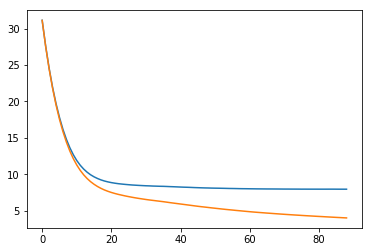

In [193]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-rmse-mean'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-rmse-mean'])

In [194]:
best_num_round = np.argmin(xgbCvResult['test-rmse-mean'])
# best_num_round = 250
print(best_num_round)

88


**Предсказания**

In [195]:
bestXgb = xgb.train(params, dtrain, best_num_round)

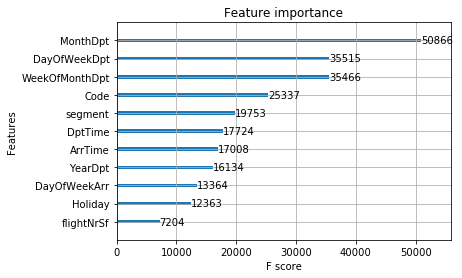

In [196]:
xgb.plot_importance(booster=bestXgb)

In [197]:
xgboost_predict_proba = [int(x)for x in bestXgb.predict(dvalid)]
for i in range(0, len(xgboost_predict_proba)):
    if xgboost_predict_proba[i] < 0:
        xgboost_predict_proba[i] = 0
        
mse = mean_squared_error(dvalid.get_label(), xgboost_predict_proba)
print('Mse: {0}'.format(mse))

Mse: 56.75521200846751


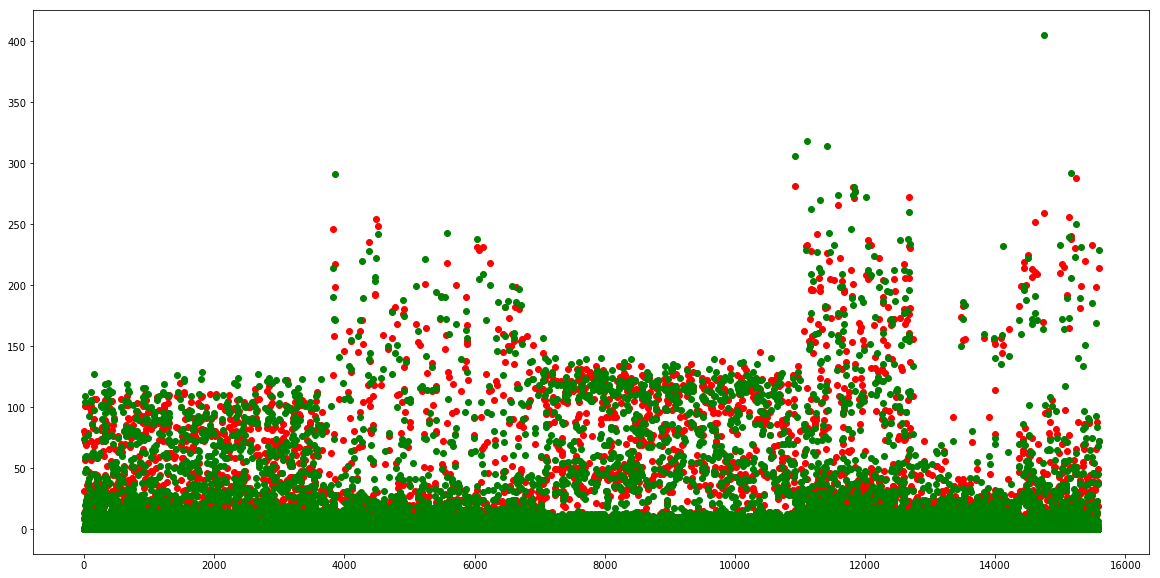

In [198]:
plt.figure(figsize=(20,10))
x = np.arange(0, len(xgboost_predict_proba))
plt.plot(x, xgboost_predict_proba, 'ro', x, dvalid.get_label(), 'go')

In [199]:
res = X_test.copy()
res['actual'] = y_test.copy()
res['predictions'] = [int(x) for x in xgboost_predict_proba]
for i in range(0, len(res.predictions)):
    if res.predictions.values[i] < 0:
        res.predictions.values[i] = 0
res.tail(125)

,FlightID,Code,fltNrDptDt,DptTime,ArrTime,flightNrSf,segment,DayOfWeekDpt,WeekOfMonthDpt,MonthDpt,...,IsWeekendDpt,DayOfWeekArr,WeekOfMonthArr,MonthArr,QuarterArr,YearArr,IsWeekendArr,Holiday,actual,predictions
22334,64217,5,2017-02-20,16,9,7,28,0,4,2,...,0,1,4,2,1,2017,0,5,39.0,23
3003,7366,2,2016-04-15,13,5,7,28,4,3,4,...,0,5,3,4,2,2016,1,0,18.0,25
1037,2515,2,2016-06-05,22,2,7,34,6,1,6,...,1,0,1,6,2,2016,0,1,0.0,0
6512,15971,3,2016-06-17,13,1,7,81,4,3,6,...,0,5,3,6,2,2016,1,2,1.0,0
12700,32738,5,2016-04-05,2,5,7,31,2,2,4,...,0,2,2,4,2,2016,0,0,1.0,1
24627,71102,4,2017-02-28,19,9,7,87,1,5,2,...,0,2,5,2,1,2017,0,2,3.0,6
25711,74495,4,2016-07-15,13,22,7,32,4,3,7,...,0,5,3,7,3,2016,1,0,5.0,0
13128,34186,4,2016-10-25,13,16,7,69,1,5,10,...,0,2,5,10,4,2016,0,0,0.0,1
5001,11608,4,2016-06-13,13,21,7,26,0,3,6,...,0,1,3,6,2,2016,0,6,4.0,7
1660,4156,4,2016-05-11,13,16,7,69,2,3,5,...,0,3,3,5,2,2016,0,5,0.0,0


## Тренировка на полных данных

In [261]:
dtrain_full = xgb.DMatrix(data.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), y)

In [263]:
xgbCvResult = xgb.cv(params, dtrain_full, num_boost_round=500, early_stopping_rounds=25, nfold=10, metrics=["rmse"], verbose_eval=True)

[0]	train-rmse:31.0541+0.0792202	test-rmse:31.0599+0.662706
[1]	train-rmse:27.049+0.156088	test-rmse:27.0625+0.603586
[2]	train-rmse:23.6677+0.203063	test-rmse:23.6926+0.480344
[3]	train-rmse:20.8613+0.248894	test-rmse:20.919+0.420671
[4]	train-rmse:18.5332+0.284983	test-rmse:18.6225+0.448787
[5]	train-rmse:16.5494+0.292104	test-rmse:16.667+0.419883
[6]	train-rmse:14.8524+0.261243	test-rmse:14.9987+0.416674
[7]	train-rmse:13.4527+0.269654	test-rmse:13.6335+0.422733
[8]	train-rmse:12.2859+0.230903	test-rmse:12.5179+0.455874
[9]	train-rmse:11.3761+0.265992	test-rmse:11.6548+0.436197
[10]	train-rmse:10.6095+0.268257	test-rmse:10.9278+0.433432
[11]	train-rmse:9.99669+0.279808	test-rmse:10.3623+0.410234
[12]	train-rmse:9.48387+0.251893	test-rmse:9.88569+0.416334
[13]	train-rmse:9.03082+0.237017	test-rmse:9.4963+0.406562
[14]	train-rmse:8.67038+0.225212	test-rmse:9.16332+0.412133
[15]	train-rmse:8.36498+0.180194	test-rmse:8.89487+0.428919
[16]	train-rmse:8.12712+0.177891	test-rmse:8.68202+0.

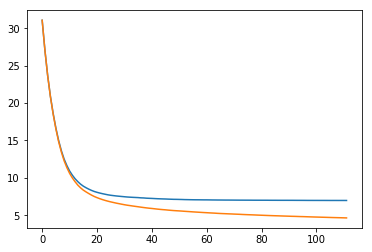

In [264]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-rmse-mean'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-rmse-mean'])

In [265]:
best_num_round = np.argmin(xgbCvResult['test-rmse-mean'])
print(best_num_round)

111


In [266]:
bestXgb = xgb.train(params, dtrain_full, best_num_round)

In [267]:
xgboost_predict_proba = [int(x)for x in bestXgb.predict(dtest)]
for i in range(0, len(xgboost_predict_proba)):
    if xgboost_predict_proba[i] < 0:
        xgboost_predict_proba[i] = 0
        
mse = mean_squared_error(dtest.get_label(), xgboost_predict_proba)
print('Mse: {0}'.format(mse))

Mse: 221.6361804995971


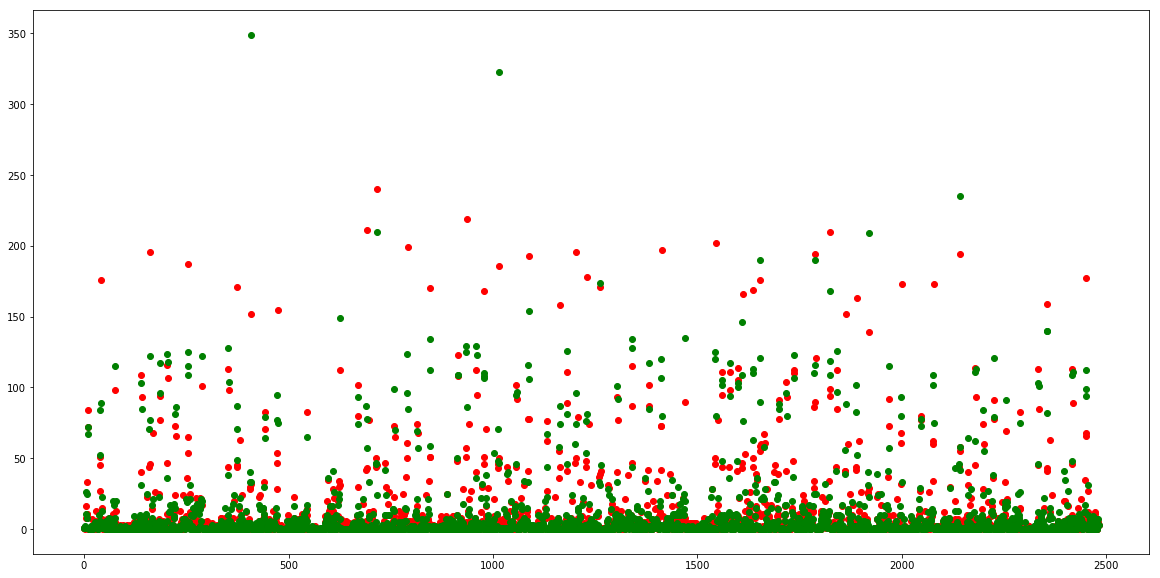

In [268]:
plt.figure(figsize=(20,10))
x = np.arange(0, len(xgboost_predict_proba))
plt.plot(x, xgboost_predict_proba, 'ro', x, dtest.get_label(), 'go')

In [269]:
res = test_data.copy()
res['actual'] = test_y.copy()
res['predictions'] = [int(x) for x in xgboost_predict_proba]
for i in range(0, len(res.predictions)):
    if res.predictions.values[i] < 0:
        res.predictions.values[i] = 0
        
res.tail(125)

,FlightID,Code,fltNrDptDt,DptTime,ArrTime,flightNrSf,segment,DayOfWeekDpt,WeekOfMonthDpt,MonthDpt,...,YearDpt,IsWeekendDpt,DayOfWeekArr,WeekOfMonthArr,MonthArr,QuarterArr,YearArr,IsWeekendArr,actual,predictions
26559,129246,2,2017-03-15,21,2,3,29,2,3,3,...,2017,0,3,3,3,1,2017,0,0.0,0
26560,129246,3,2017-03-15,21,2,3,29,2,3,3,...,2017,0,3,3,3,1,2017,0,0.0,0
26561,129246,4,2017-03-15,21,2,3,29,2,3,3,...,2017,0,3,3,3,1,2017,0,0.0,0
26562,129246,2,2017-03-15,21,5,3,30,2,3,3,...,2017,0,3,3,3,1,2017,0,7.0,8
26563,129246,3,2017-03-15,21,5,3,30,2,3,3,...,2017,0,3,3,3,1,2017,0,10.0,12
26564,129246,4,2017-03-15,21,5,3,30,2,3,3,...,2017,0,3,3,3,1,2017,0,15.0,63
26565,129246,2,2017-03-15,22,2,3,34,2,3,3,...,2017,0,3,3,3,1,2017,0,0.0,0
26566,129246,3,2017-03-15,22,2,3,34,2,3,3,...,2017,0,3,3,3,1,2017,0,0.0,0
26567,129246,2,2017-03-15,22,5,3,35,2,3,3,...,2017,0,3,3,3,1,2017,0,1.0,1
26568,129246,3,2017-03-15,22,5,3,35,2,3,3,...,2017,0,3,3,3,1,2017,0,2.0,0


In [270]:
res.to_excel("whole_results_" + str(mse) + ".xls")

In [271]:
# todo: refactor using groupby
res_s = pd.DataFrame(columns = ("FlightID", "Code", "Date", "FltNr", "actual", "predictions"))
count = 0
for flightID in unique(res.FlightID.values):
    for code in unique(res.Code[res.FlightID == flightID].values):
        date = res.fltNrDptDt[res.FlightID == flightID][res.Code == code].values[0]
        fltNr = res.flightNrSf[res.FlightID == flightID][res.Code == code].values[0]
        res_s.loc[count] = (flightID, code, date, fltNr, sum(res.actual[res.FlightID == flightID][res.Code == code].values), sum(res.predictions[res.FlightID == flightID][res.Code == code].values))
        count += 1

In [272]:
print('Mse: {0}'.format(mean_squared_error(res_s.actual, res_s.predictions)))
res_s.head(50)

Mse: 3218.5078864353313


,FlightID,Code,Date,FltNr,actual,predictions
0,44319,0,2017-03-27,0,10.0,11
1,44319,1,2017-03-27,0,38.0,42
2,44319,2,2017-03-27,0,99.0,102
3,44319,3,2017-03-27,0,76.0,84
4,44438,2,2017-03-27,1,73.0,58
5,44438,3,2017-03-27,1,96.0,51
6,44438,4,2017-03-27,1,108.0,242
7,44576,2,2017-03-27,6,30.0,14
8,44576,3,2017-03-27,6,13.0,8
9,44576,4,2017-03-27,6,194.0,178


In [273]:
res_s.to_excel("results_" + str(mse) + ".xls")

**Запишем в базу**

In [ ]:
import codecs
import lxml
from lxml import etree
import os
from mmap import mmap
import re
from os import listdir
from os.path import isfile, join
import MySQLdb
from datetime import datetime

In [ ]:
def proccess_flight(flight):
    
    # day timestamp
    reportDt = inventory_file.split("_")[1].split(".")[0]
    
    # insert flight
    cur.execute("INSERT INTO Flight(Carrier, fltNr, opsSuffix, fltNrDptDt, fltNrArrDt) VALUES(%s, %s, %s, %s, %s)", 
                (flight.flightId.carrier, int(flight.flightId.fltNr), flight.flightId.opsSuffix, 
                 datetime.strptime(flight.flightId.fltNrDptDt, "%d%m%y").date(), datetime.strptime(flight.flightId.fltNrArrDt, "%d%m%y").date()))
    flightId = cur.lastrowid
    
    # insert legs
    for leg in flight.legs:
        cur.execute("INSERT INTO Leg(DptDt, DptTime, ArrDt, ArrTime, orig, dest, fkFlightID) VALUES(%s, %s, %s, %s, %s, %s, %s)",
                (datetime.strptime(leg.dptDt, "%d%m%y").date(), datetime.strptime(leg.dptTime, "%H%M").time(), 
                 datetime.strptime(leg.arrDt, "%d%m%y").date(), datetime.strptime(leg.arrTime, "%H%M").time(),
                 leg.orig, leg.dest, int(flightId)))
        legId = cur.lastrowid

In [ ]:
fltNrs = ('88J', '87J','102J', '101J', '337J', '337ZH', '50M', '49J', '10J', '9J', '138J', '137YQ')
db = MySQLdb.connect(host="194.247.15.117", 
                     port=7806,
                     user="bar",
                     passwd="PASSWORD",
                     db="Inventory")

inventory_path = '../inventory/rm-in/copy'
for inventory_file in [f for f in listdir(inventory_path) if isfile(join(inventory_path, f))]:
    if inventory_file.endswith('.xml'):
        db.autocommit(True) 
        cur = db.cursor()
        context = etree.iterparse(inventory_path + '/' + inventory_file)
        fast_iter(context, process_element)
        print(inventory_file + ' loading into db complete ' + str(datetime.now()))
        # db.close()
        cur.close()